# Read and Visualize ERA5-Land Global data


"ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5. ERA5-Land has been produced by replaying the land component of the ECMWF ERA5 climate reanalysis. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. Reanalysis produces data that goes several decades back in time, providing an accurate description of the climate of the past."



The data can be downloaded here:

https://cds.climate.copernicus.eu/cdsapp#!/home


------------------------
DTR


# Import packages

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import xarray as xr

In [4]:
#import dask

In [5]:
import rioxarray

In [6]:
import cartopy

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [8]:
import cartopy.io.img_tiles as cimgt

In [55]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [9]:
import os

# Working Directory

In [10]:
os.getcwd()

'/media/donald/disk4nvme/GEOSPATIAL_DATA_READ_PROCESS'

## Data

In [12]:
dir_data = '/media/donald/disk10/DATA_GEOSPATIAL_SAT_READ/ERA5_Land/ERA5LAND_GLOB_T2M/'
dir_data

'/media/donald/disk10/DATA_GEOSPATIAL_SAT_READ/ERA5_Land/ERA5LAND_GLOB_T2M/'

In [14]:
os.listdir(dir_data)

['ERA5L_GBLOB_T2M_MON.nc']

list the files

In [15]:
lst_Files = [fl for fl in os.listdir(dir_data) if fl.endswith('.nc') ]
lst_Files

['ERA5L_GBLOB_T2M_MON.nc']

In [16]:
os.path.join(dir_data, lst_Files[0] )

'/media/donald/disk10/DATA_GEOSPATIAL_SAT_READ/ERA5_Land/ERA5LAND_GLOB_T2M/ERA5L_GBLOB_T2M_MON.nc'

# File size and memory checks

In [17]:
def convert_bytes(byt_num):
    """
    this function will convert bytes to KB, MB, GB and TB
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if byt_num < 1024.0:
            return "%3.1f %s" % (byt_num, x)
        byt_num /= 1024.0
    return byt_num
        

In [18]:
def check_filesize(file_path):
    """
    function to check the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)

In [19]:
check_filesize(os.path.join(dir_data, lst_Files[0] ))

'148.4 MB'

# Explore the dataset using Xarray

Often the common choice for reading geotiff files is gdal or rasterio. Here we going to try something different

In [20]:
FILE_NAME = os.path.join(dir_data, lst_Files[0] )
FILE_NAME

'/media/donald/disk10/DATA_GEOSPATIAL_SAT_READ/ERA5_Land/ERA5LAND_GLOB_T2M/ERA5L_GBLOB_T2M_MON.nc'

In [34]:
ds_ERA5L = xr.open_dataset(FILE_NAME, decode_coords="all" )

In [35]:
ds_ERA5L

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1801, time: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-13 14:22:09 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [36]:
# was the georeference read?
ds_ERA5L.rio.crs

In [37]:
ds_ERA5L.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (longitude: 3600, latitude: 1801, time: 12)
Coordinates:
  * longitude    (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-13 14:22:09 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [38]:
# was the georeference read?
ds_ERA5L.rio.crs

CRS.from_epsg(4326)

In [39]:
ds_ERA5L.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...

Geotransform values mean:


    [0] : top left x
    [1] : w-e pixel resolution
    [2] : rotation, 0 if image is "north up"
    [3] : top left y
    [4] : rotation, 0 if image is "north up"
    [5] : n-s pixel resolution

quick view

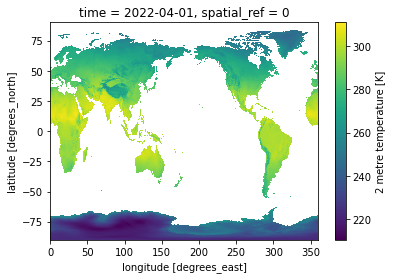

In [41]:
ds_ERA5L['t2m'].isel(time=3).plot()

As we can see the centre is not a zero degrees because the longitude coordinates are not running -180 to + 180 degrees. We need to modify this

In [42]:
ds_ERA5L.coords['longitude'] = (ds_ERA5L.coords['longitude'] + 180) % 360 - 180

In [46]:
#and sort
ds_ERA5L = ds_ERA5L.sortby(ds_ERA5L.longitude)

In [47]:
ds_ERA5L

<xarray.Dataset>
Dimensions:      (longitude: 3600, latitude: 1801, time: 12)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    t2m          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-13 14:22:09 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

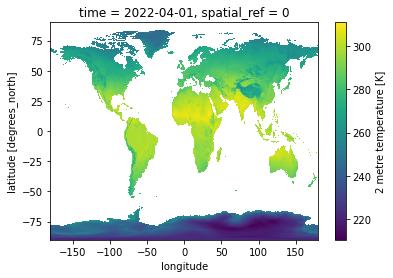

In [48]:
ds_ERA5L['t2m'].isel(time=3).plot()

# Convert Kelvins to Degrees C

In [64]:
ds_ERA5L['t2m_degC'] = ds_ERA5L['t2m'] - 273.15

# Plot the data - Single Image

In [155]:
#stamen_terrain = cimgt.Stamen('terrain-background')

In [59]:
ds_ERA5L['t2m'].time.values[0]

numpy.datetime64('2022-01-01T00:00:00.000000000')

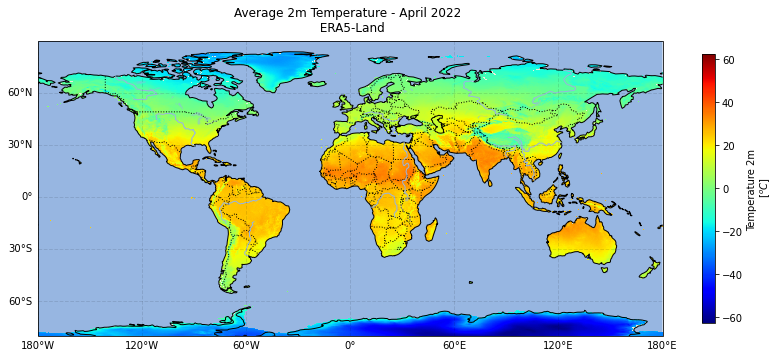

In [65]:
fig = plt.figure()
fig.set_size_inches(14, 11)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#set_extent(extents, crs=None)[source]
#Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
#If no crs is given, the extents’ coordinate system will be assumed to be the Geodetic
#version of this axes’ projection.
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())
## add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
### add background
#ax.add_image(stamen_terrain, 8)
### add data
ds_ERA5L['t2m_degC'].isel(time=3).plot(cmap=plt.cm.jet,
                                  cbar_kwargs={"label": "Temperature 2m \n [$^o C$]", 'shrink':0.45})

#plt.colorbar().set_title('',fontsize=8)
##########
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="k", alpha=0.1, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.ylines = True
#gl.xlines = True

###
ax.set_title('Average 2m Temperature - April 2022 \n ERA5-Land', y=1.01)


plt.show()


# Compute  Annual Average

In [78]:
t2m_annual = ds_ERA5L['t2m_degC'].mean('time')

In [79]:
t2m_annual

<xarray.DataArray 't2m_degC' (latitude: 1801, longitude: 3600)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-45.022873, -45.023285, -45.023285, ..., -45.024677, -45.023983,
        -45.02371 ],
       [-45.0237  , -45.0237  , -45.02426 , ..., -45.024677, -45.024536,
        -45.02412 ],
       [-44.997433, -44.997433, -44.997433, ..., -44.997433, -44.997433,
        -44.997433]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
    spatial_ref  int64 0

## Plot Annual average T2M

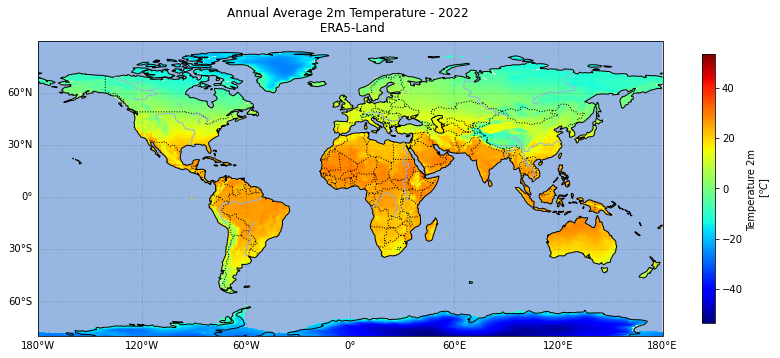

In [83]:
fig = plt.figure()
fig.set_size_inches(14, 11)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#set_extent(extents, crs=None)[source]
#Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
#If no crs is given, the extents’ coordinate system will be assumed to be the Geodetic
#version of this axes’ projection.
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())
## add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
### add background
#ax.add_image(stamen_terrain, 8)
### add data
t2m_annual.plot(cmap=plt.cm.jet,
                cbar_kwargs={"label": "Temperature 2m \n [$^o C$]", 'shrink':0.45})

#plt.colorbar().set_title('',fontsize=8)
##########
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="k", alpha=0.1, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.ylines = True
#gl.xlines = True

###
ax.set_title('Annual Average 2m Temperature - 2022 \n ERA5-Land', y=1.01, fontsize=12)


plt.show()
